In [4]:
!pip install torchvision

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print("PyTorch Version: {}".format(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:{}".format(device))


PyTorch Version: 1.9.0+cu102
device:cuda:0


**Dataset**



In [9]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/',train=True, transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False, transform=transforms.ToTensor(),download=True)
print("mnist_train:\n",mnist_train,"\n")
print("mnist_test:\m",mnist_test,"\n")
print("Done .")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:\m Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done .


In [36]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print(len(train_iter))


235


In [13]:
class MultiLayerPerceptronClass(nn.Module):

  def __init__(self, name='mlp',xdim=784, hdim=256, ydim=10):
    super(MultiLayerPerceptronClass,self).__init__()
    self.name = name
    self.xdim = xdim
    self.hdim = hdim
    self.ydim = ydim
    self.lin_1 = nn.Linear(self.xdim, self.hdim)
    self.lin_2 = nn.Linear(self.hdim, self.ydim)
    self.init_param() 
  
  def init_param(self):
    nn.init.kaiming_normal_(self.lin_1.weight)
    nn.init.zeros_(self.lin_1.bias)
    nn.init.kaiming_normal_(self.lin_2.weight)
    nn.init.zeros_(self.lin_2.bias)

  def forward(self,x):
    net = x
    net = self.lin_1(net)
    net = F.relu(net)
    net = self.lin_2(net)
    return net

M = MultiLayerPerceptronClass().to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(),lr=1e-3)
print('Done. ')

Done. 


In [15]:
x_numpy = np.random.rand(2,784)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch)
y_numpy = y_torch.detach().cpu().numpy()
print("x_numpy:\n",x_numpy)
print("x_torch:\n", x_torch)
print("y_torch:\n", y_torch)
print("y_numpy:\n", y_numpy)


x_numpy:
 [[0.15072384 0.69619631 0.31769105 ... 0.67130337 0.57108279 0.3385851 ]
 [0.30202186 0.13829642 0.85861762 ... 0.89334555 0.05093231 0.36823652]]
x_torch:
 tensor([[0.1507, 0.6962, 0.3177,  ..., 0.6713, 0.5711, 0.3386],
        [0.3020, 0.1383, 0.8586,  ..., 0.8933, 0.0509, 0.3682]],
       device='cuda:0')
y_torch:
 tensor([[-0.7171, -0.5695, -1.0649,  1.1261,  1.0055, -0.7426, -0.1303, -0.7589,
         -0.9802, -0.4953],
        [-0.5963, -1.0310, -0.3036,  0.9328,  1.0651, -1.7794, -0.0317, -0.3702,
         -0.8271, -0.2572]], device='cuda:0', grad_fn=<AddmmBackward>)
y_numpy:
 [[-0.71714914 -0.56953394 -1.0649097   1.1260903   1.0055251  -0.7426313
  -0.13029192 -0.75894374 -0.980213   -0.49532208]
 [-0.59634304 -1.0310189  -0.30364797  0.93282646  1.0650982  -1.7794006
  -0.03172261 -0.37019533 -0.82713926 -0.25716558]]


**chcek Params**

In [27]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(M.named_parameters()):
  param_numpy = param.detach().cpu().numpy()
  n_param += len(param_numpy.reshape(-1))
  print("[%d] name: [%s] shape: [%s]"%(p_idx,param_name,param_numpy.shape))
  print("    val: %s"%(param_numpy.reshape(-1)[:5]))
print("Total number of parameters:[%s]"%(format(n_param,',d')))

[0] name: [lin_1.weight] shape: [(256, 784)]
    val: [-0.042  0.036  0.064  0.062 -0.031]
[1] name: [lin_1.bias] shape: [(256,)]
    val: [0. 0. 0. 0. 0.]
[2] name: [lin_2.weight] shape: [(10, 256)]
    val: [ 0.038  0.112 -0.14   0.18  -0.035]
[3] name: [lin_2.bias] shape: [(10,)]
    val: [0. 0. 0. 0. 0.]
Total number of parameters:[203,530]


**Evaluation Function**

In [30]:
def func_eval(model, data_iter, device):
  with torch.no_grad():
    model.eval()
    n_total, n_correct = 0, 0
    for batch_in, batch_out in data_iter:
      y_trgt = batch_out.to(device)
      model_pred = model(batch_in.view(-1,28*28).to(device))
      _,y_pred = torch.max(model_pred.data,1)
      n_correct += (y_pred==y_trgt).sum().item()
      n_total += batch_in.size(0)
    val_accr = (n_correct/n_total)
    model.train()
    return val_accr
print(" DONE ")


 DONE 


In [32]:
train_accr = func_eval(M, train_iter, device)
test_accr = func_eval(M,test_iter, device)
print( "train_accr:[%.3f] test_accr:[%.3f]"%(train_accr,test_accr))


train_accr:[0.111] test_accr:[0.111]


In [37]:
print("Start training")
M.init_param()
M.train()
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
  loss_val_sum = 0
  for batch_in, batch_out in train_iter:
    y_pred = M.forward(batch_in.view(-1,28*28).to(device))
    loss_out = loss(y_pred,batch_out.to(device))
    optm.zero_grad()
    loss_out.backward()
    optm.step()
    loss_val_sum += loss_out
  loss_val_avg = loss_val_sum/len(train_iter)
  if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
    train_accr = func_eval(M, train_iter,device)
    test_accr = func_eval(M,test_iter,device)
    print("epoch:[%d] loss[%.3f] train_accr:[%.3f] test_accr:[%.3f]"%(epoch,loss_val_avg,train_accr,test_accr))
print("DONE")  
   

Start training
epoch:[0] loss[0.388] train_accr:[0.943] test_accr:[0.942]
epoch:[1] loss[0.169] train_accr:[0.965] test_accr:[0.959]
epoch:[2] loss[0.118] train_accr:[0.974] test_accr:[0.970]
epoch:[3] loss[0.091] train_accr:[0.980] test_accr:[0.973]
epoch:[4] loss[0.072] train_accr:[0.985] test_accr:[0.974]
epoch:[5] loss[0.058] train_accr:[0.988] test_accr:[0.976]
epoch:[6] loss[0.049] train_accr:[0.989] test_accr:[0.976]
epoch:[7] loss[0.040] train_accr:[0.992] test_accr:[0.978]
epoch:[8] loss[0.033] train_accr:[0.994] test_accr:[0.979]
epoch:[9] loss[0.029] train_accr:[0.994] test_accr:[0.979]
DONE


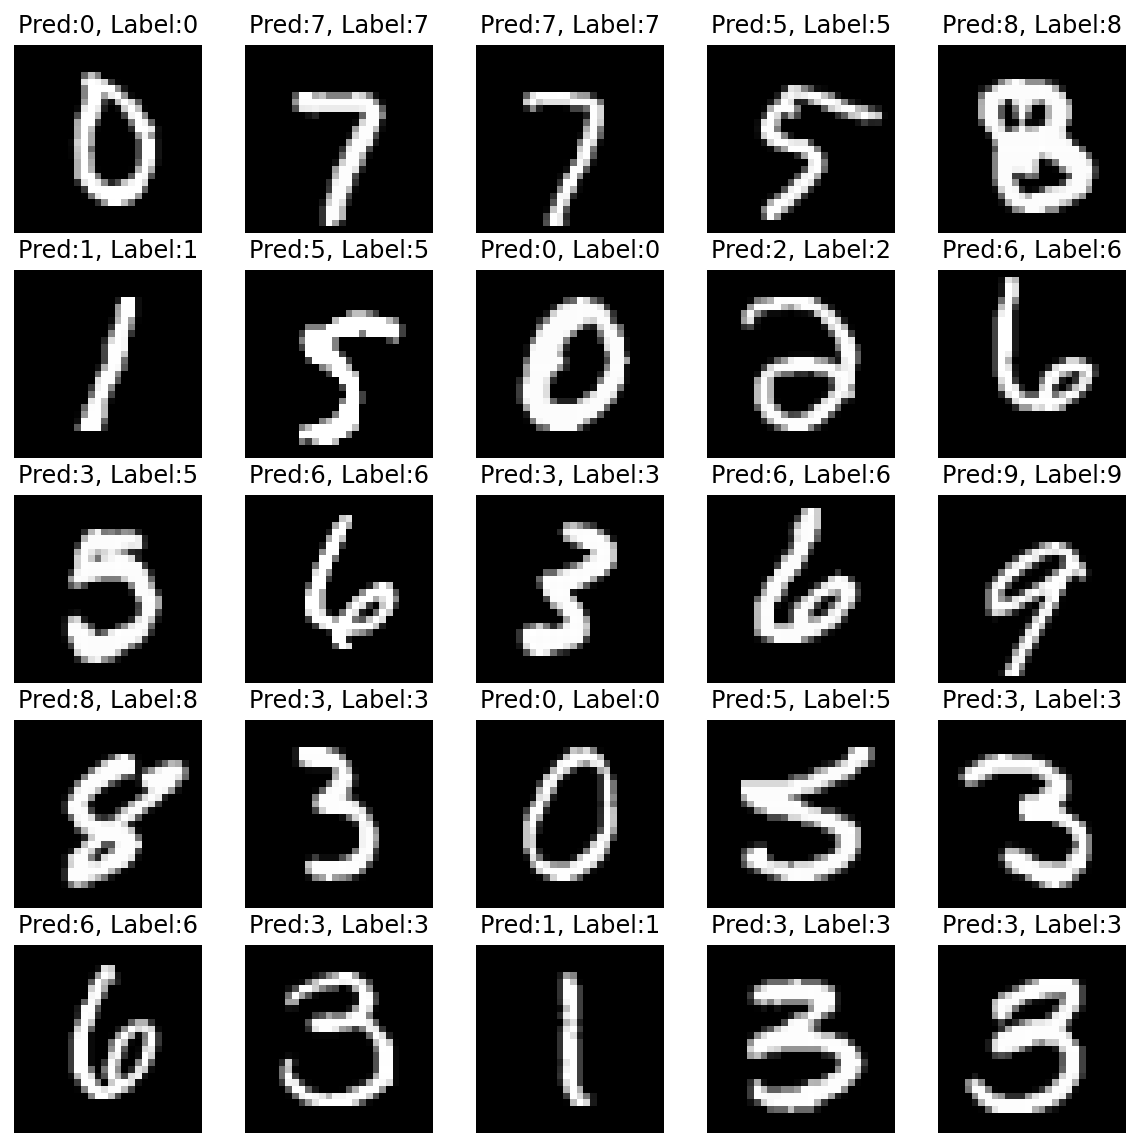

Done


In [38]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
  y_pred = M.forward(test_x.view(-1,28*28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
  plt.subplot(5 , 5 , idx+1)
  plt.imshow(test_x[idx],cmap='gray')
  plt.axis('off')
  plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()
print("Done")
